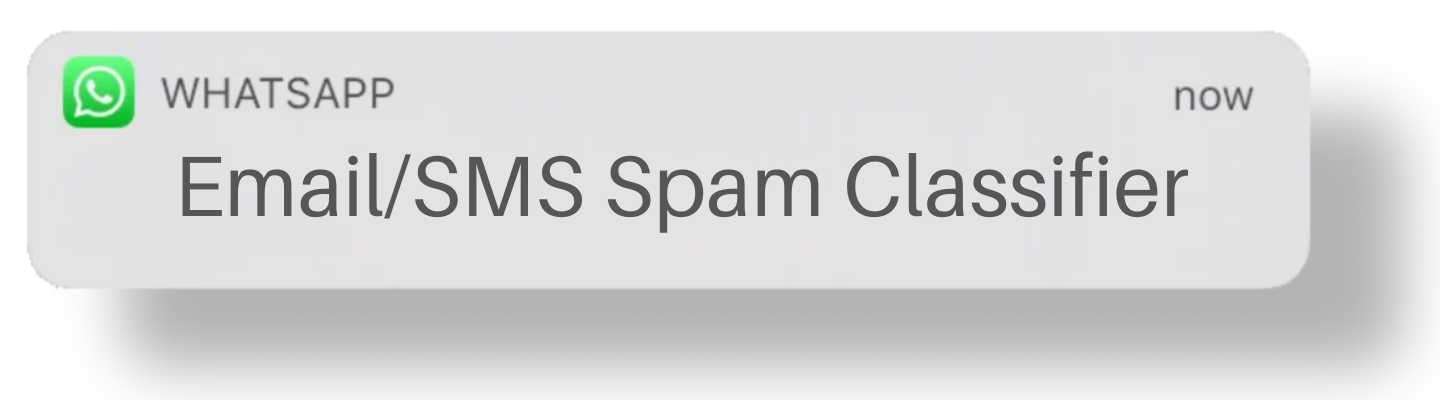

<div class='alert alert-box alert-success'>
        <b>Table of Contents<b>    
            
1. [Importing Libraries & Data](#lib_data)
2. [Exploratory Data Analysis](#EDA)
3. [Visualizations (before preprocessing)](#VIZB4PP)
4. [Pre-processing](#PP)
5. [Visualizations (post-proecssing)](#VIZAP)
6. [Training the Model](#training)
7. [Predicting Data](#predicting)
8. [Performance of the Model](#performance)

***
<div class='alert alert-success'>
    <b>1. Importing Libraries and Data<b>
        <a id="lib_data"></a> 

In [1]:
# essential libraries to read data
import pandas as pd
import numpy as np

# libraries to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# using plotly.io to show static versions of the plotly.express plots, due to plotly.express plots not rendering in github. 
# If you'd like to see a detailed(immersive) version of the plots please download the notebook!
import plotly.io as pio 
pio.renderers.default = "svg" # ← and comment this line

# Libraries for NLP 
import nltk
from nltk.corpus import stopwords
import string
import re
from collections import Counter

# Libraries to build the model
from textblob import TextBlob, Word
from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier

# Libraries to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data\spam.csv', encoding="ISO-8859-1")
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


- Had to add the encoding type due an __UTF-8__ encoding error 
- __3 additional columns__ can be seen: (dropping these)
    - `_Unnamed: 2_`
    - `_Unnamed: 3_`
    - `_Unnamed: 4_`

In [3]:
# dropping the additional columns
df = df.drop(df[['Unnamed: 2','Unnamed: 3','Unnamed: 4']],axis=1)

***
<div class="alert alert-success">
    <b>2. EDA<b>
        <a id='EDA'></a>

In [4]:
# coverting all the strings to lower-case to avoid any ambiguities
df.v2 = df.v2.apply(lambda x: x.lower())

In [5]:
# Looking at a data sample
df.v2.sample()

2496    hcl chennai requires freshers for voice proces...
Name: v2, dtype: object

In [6]:
# Percentage and Count of the labels
print (f"HAM: \nPercentage: {round(len(df[df.v1=='ham']) / len(df.v1),2)*100}%\nCount: {df.v1.value_counts()[0]}\n")
print (f"SPAM: \nPercentage: {round(len(df[df.v1=='spam']) / len(df.v1),2)*100}%\nCount: {df.v1.value_counts()[1]}")

HAM: 
Percentage: 87.0%
Count: 4825

SPAM: 
Percentage: 13.0%
Count: 747


In [7]:
# counting the number of words in the v2 column

data = pd.DataFrame()
data["Number of Words"] = df["v2"].apply(lambda x: len(x.split()))
print("Total Number of Words in the dataset →", data["Number of Words"].sum())

Total Number of Words in the dataset → 86335


In [8]:
# adding a the "ham" or "spam" classification column
data['Classification'] = [x for x in df['v1']]

# checking if the data has emails in them and adding a count for that
data['Email'] = [x for x in df.v2.str.contains(r"^.+@.+\..{2,}$")]
data.Email.value_counts()

data.head()

,Number of Words,Classification,Email
0,20,ham,False
1,6,ham,False
2,28,spam,False
3,11,ham,False
4,13,ham,False


In [9]:
# counting punctuations in a row
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

data['Punctuations'] = df.v2.apply(lambda s: count(s, string.punctuation))
print(f"Total Number of Punctuations in the dataset → {data['Punctuations'].sum()}")

Total Number of Punctuations in the dataset → 23446


In [10]:
# accumulating the punctuations
df['acc_punct_dict'] = df.v2.apply(lambda s: {k:v for k, v in Counter(s).items() if k in string.punctuation})
df_punctuations = df.acc_punct_dict.apply(pd.Series).fillna('0.0')

# replacing null values with zero
df_punctuations = df_punctuations.astype('float')

# creating a dataframe with the punctuations and their counts
df_punctuations_count = pd.DataFrame({'Sum':df_punctuations[df_punctuations.columns].sum(axis=0)})
df_punctuations_count.sort_values(by='Sum',ascending=False)

,Sum
.,11048.0
",",1913.0
',1871.0
?,1541.0
!,1381.0
&,916.0
;,764.0
:,740.0
-,574.0
),494.0


<div class='alert alert-success'>
    <b>3. Visualizations (before preprocessing)<b>
        <a id='VIZB4PP'></a>

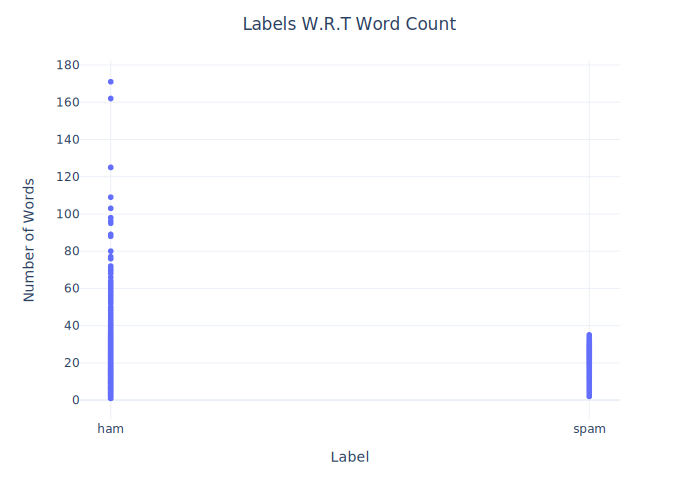

In [11]:
# plotting number of words in sentences marked as ham and spam 
fig = px.scatter(x=df['v1'],y=data['Number of Words'], template='plotly_white')
fig.update_layout(title_text='Labels W.R.T Word Count', title_x=0.5)
fig.update_xaxes(title='Label').update_yaxes(title='Number of Words')
fig.show()

__Observation: 🔎__
- There is a noticeable difference in the number of words used in a SPAM messages.
- Spam messages tend to have considerably __low number of words in them as compared to normal messages__.

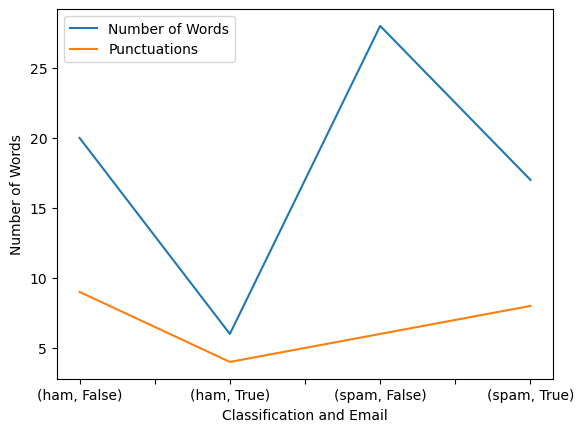

In [13]:
data.groupby(['Classification','Email']).first().plot()
plt.xlabel("Classification and Email")
plt.ylabel("Number of Words")
plt.show()

__Observation: 🔎__
- Although, it's not an accurate measurement of depicting spam messages. It is worthy to note that __messages with _higher number of words_ that include _emails_ are more likely to be spams__.

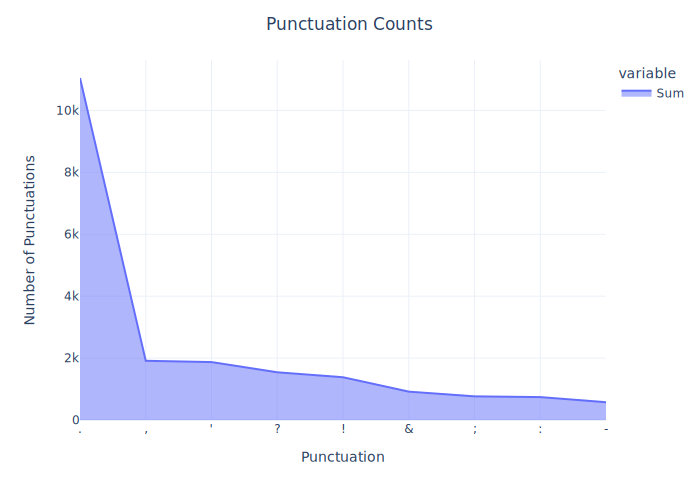

In [14]:
# plotting the punctuations and its counts
fig = px.area(df_punctuations_count.sort_values(by='Sum',ascending=False)[:9], template='plotly_white')
fig.update_layout(title_text='Punctuation Counts', title_x=0.5)
fig.update_xaxes(title='Punctuation').update_yaxes(title='Number of Punctuations')
fig.show()

__Observation: 🔎__
- As expected, `.` and `,` have the first and second highest counts respectively.
- followed by `'` , `?` , `!` and `&` .

***
<div class='alert alert-success'>
    <b>4. Preprocessing<b>
        <a id='PP'></a>

In [16]:
# Replace email addresses with 'email'
df['v2'] = df['v2'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'email')

# Replace URLs with 'url'
df['v2'] = df['v2'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'url')

# Replace money symbols with 'currency'
df['v2'] = df['v2'].str.replace(r'£|\$', 'currency')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['v2'] = df['v2'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')
    
# Replace numbers with 'number'
df['v2'] = df['v2'].str.replace(r'\d+(\.\d+)?', 'number')

# Remove punctuation
df['v2'] = df['v2'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['v2'] = df['v2'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['v2'] = df['v2'].str.replace(r'^\s+|\s+?$', '')

# removing escapes, tab spaces
df = df.replace(to_replace=[r"\\t|\\n|\\r","\t|\n|\r"], value=["",""], regex=True)

In [17]:
# remove stopwords
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure','ȧ'])
df['v2'] = df['v2'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [18]:
# lemmatizing the rest of the data
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [' '.join(str(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize(text))]

df['Lemmatized Text'] = df.v2.apply(lemmatize_text)
df['Lemmatized Text'] = [str(x).strip("'[]'") for x in df['Lemmatized Text']]

In [19]:
df = df.drop('acc_punct_dict',axis=1)

# removing non-ascii words
df['Lemmatized Text'] = df['Lemmatized Text'].str.encode('ascii','ignore').str.decode('ascii')

# removing alpha-numeric characters
def cleanse(word):
    rx = re.compile(r"\D*\d")
    if rx.match(word):
        return ''
    return word
def remove_alphanumeric(strings):
    nstrings = [" ".join(filter(None, (
    cleanse(word) for word in string.split())))
               for string in strings.split()]
    str1 = ' '.join(nstrings)
    return str1

df['Lemmatized Text']= df['Lemmatized Text'].apply(remove_alphanumeric)

# renaming the columns 
df = df.rename(columns = {'v1':'Labels'})
df.head()

,Labels,v2,Lemmatized Text
0,ham,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif oni,ok lar joking wif oni
2,spam,free entry number wkly comp win fa cup final t...,free entry number wkly comp win fa cup final t...
3,ham,dun say early hor c already say,dun say early hor c already say
4,ham,nah think goes usf lives around though,nah think go usf life around though


In [20]:
# looking at the number of words after cleaning them
data["Cleaned Number of Words"] = df["v2"].apply(lambda x: len(x.split()))
print("Total Number of Words after cleaning →", data["Cleaned Number of Words"].sum())

Total Number of Words after cleaning → 51133


In [21]:
# checking how many words were removed
print("Number of words removed →",data["Number of Words"].sum() - data["Cleaned Number of Words"].sum())

Number of words removed → 35202


In [22]:
# creating a column which includes the sentiments of the messages
df['Sentiment'] = df['Lemmatized Text'].apply(lambda x: TextBlob(x).sentiment)
df.head()

,Labels,v2,Lemmatized Text,Sentiment
0,ham,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...,"(0.20000000000000004, 0.6833333333333332)"
1,ham,ok lar joking wif oni,ok lar joking wif oni,"(0.5, 0.5)"
2,spam,free entry number wkly comp win fa cup final t...,free entry number wkly comp win fa cup final t...,"(0.4000000000000001, 0.7333333333333334)"
3,ham,dun say early hor c already say,dun say early hor c already say,"(0.1, 0.3)"
4,ham,nah think goes usf lives around though,nah think go usf life around though,"(0.0, 0.0)"


- The `Sentiment` column now contains the __polarity__ and __subjectivity__ of the message respectively

In [23]:
sentiment_series = df['Sentiment'].tolist()
columns = ['Polarity', 'Subjectivity']
df_pol_sub = pd.DataFrame(sentiment_series, columns=columns, index=df.index)

# concatenating the two dataframes to create a more detailed dataframe
result = pd.concat([df,df_pol_sub],axis=1)
result = result.drop(['v2','Sentiment'],axis=1)
result.head()

,Labels,Lemmatized Text,Polarity,Subjectivity
0,ham,go jurong point crazy available bugis n great ...,0.2,0.683333
1,ham,ok lar joking wif oni,0.5,0.500000
2,spam,free entry number wkly comp win fa cup final t...,0.4,0.733333
3,ham,dun say early hor c already say,0.1,0.300000
4,ham,nah think go usf life around though,0.0,0.000000


In [24]:
# if polarity>0.3 → Postive Sentiment  else: Negative Sentiment
result.loc[result['Polarity']>=0.3, 'Sentiment'] = "Positive"
result.loc[result['Polarity']<0.3, 'Sentiment'] = "Negative"
result.head()

,Labels,Lemmatized Text,Polarity,Subjectivity,Sentiment
0,ham,go jurong point crazy available bugis n great ...,0.2,0.683333,Negative
1,ham,ok lar joking wif oni,0.5,0.500000,Positive
2,spam,free entry number wkly comp win fa cup final t...,0.4,0.733333,Positive
3,ham,dun say early hor c already say,0.1,0.300000,Negative
4,ham,nah think go usf life around though,0.0,0.000000,Negative


***
<div class='alert alert-success'>
    <b>5. Visualization Post Processing<b>
        <a id='VIZAP'></a>

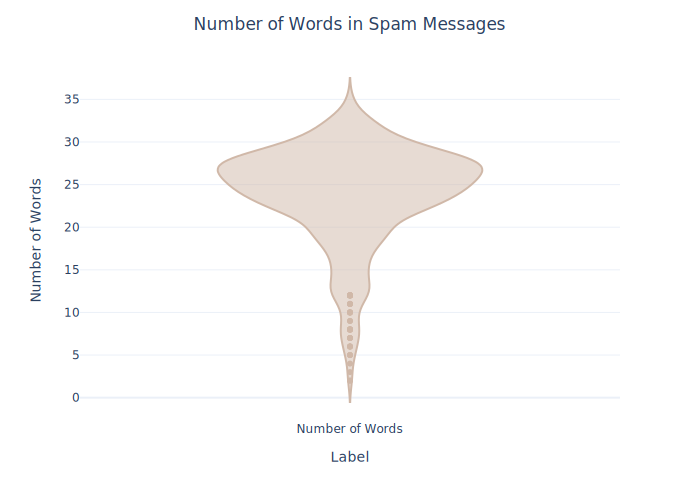

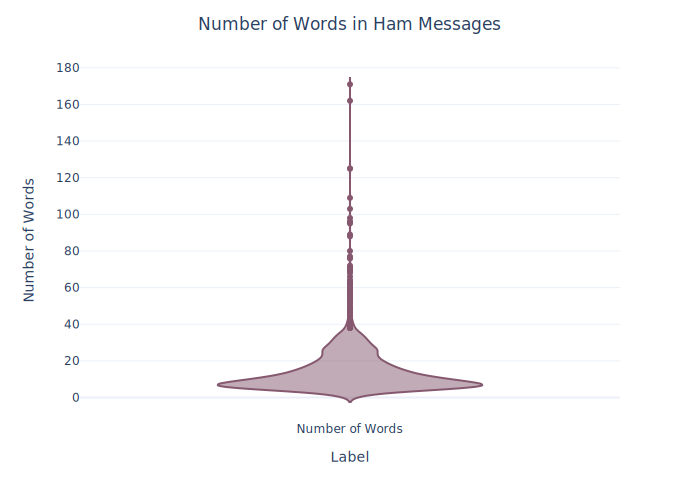

In [25]:
# plotting distribution of number of words in sentences BEFORE it was cleaned - SPAM
fig1 = px.violin(data[data['Classification']=="spam"]['Number of Words'], template='plotly_white',
                color_discrete_sequence= ['#D0B8A8'])
fig1.update_layout(title_text='Number of Words in Spam Messages', title_x=0.5)
fig1.update_xaxes(title='Label').update_yaxes(title='Number of Words')
fig1.show()

# plotting number of words in sentences BEFORE cleaned - HAM
fig2 = px.violin(data[data['Classification']=="ham"]['Number of Words'], template='plotly_white',
                   color_discrete_sequence= ['#85586F'])
fig2.update_layout(title_text='Number of Words in Ham Messages', title_x=0.5)
fig2.update_xaxes(title='Label').update_yaxes(title='Number of Words')
fig2.show()

__Observation: 🔎__
- Highest distribution of words _(a.k.a median)_ in __SPAM messages seem to be `25`__
- Highest distribution of words in __HAM messages seem to be `11`__

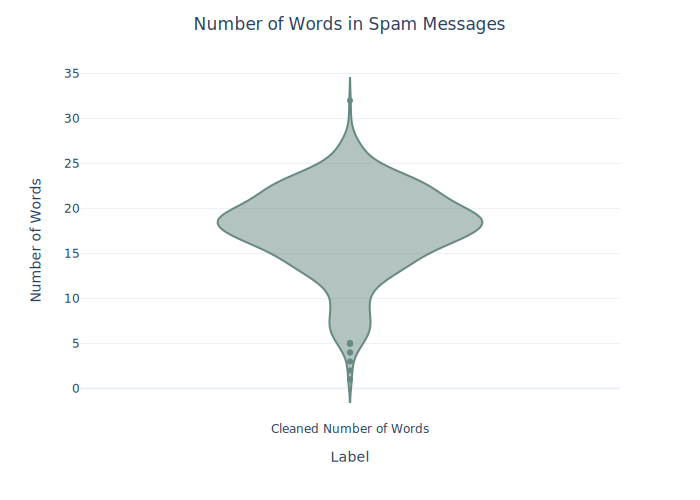

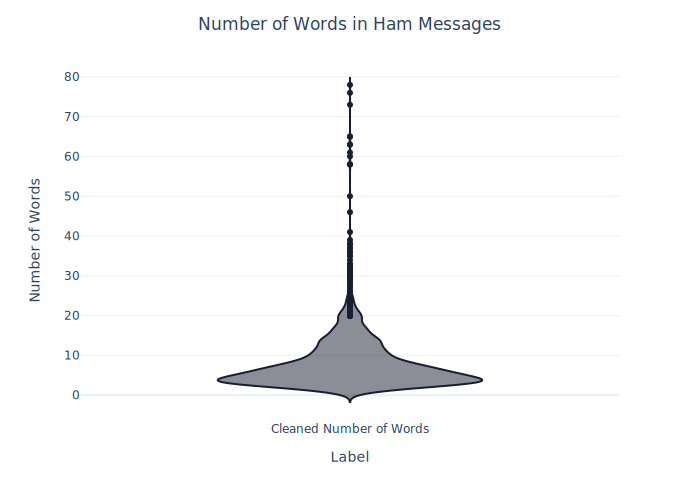

In [27]:
# plotting number of words in sentences AFTER cleaned - SPAM
fig3 = px.violin(data[data['Classification']=="spam"]['Cleaned Number of Words'], template='plotly_white',
               color_discrete_sequence= ['#678983'])
fig3.update_layout(title_text='Number of Words in Spam Messages', title_x=0.5)
fig3.update_xaxes(title='Label').update_yaxes(title='Number of Words')
fig3.show()

# plotting number of words in sentences AFTER cleaned - HAM
fig4 = px.violin(data[data['Classification']=="ham"]['Cleaned Number of Words'], template='plotly_white',
               color_discrete_sequence= ['#181D31'])
fig4.update_layout(title_text='Number of Words in Ham Messages', title_x=0.5)
fig4.update_xaxes(title='Label').update_yaxes(title='Number of Words')
fig4.show()

__Observation: 🔎__
- Highest distribution of words _(a.k.a median)_ in __SPAM messages seem to be `18`__
- Highest distribution of words in __HAM messages seem to be `6`__

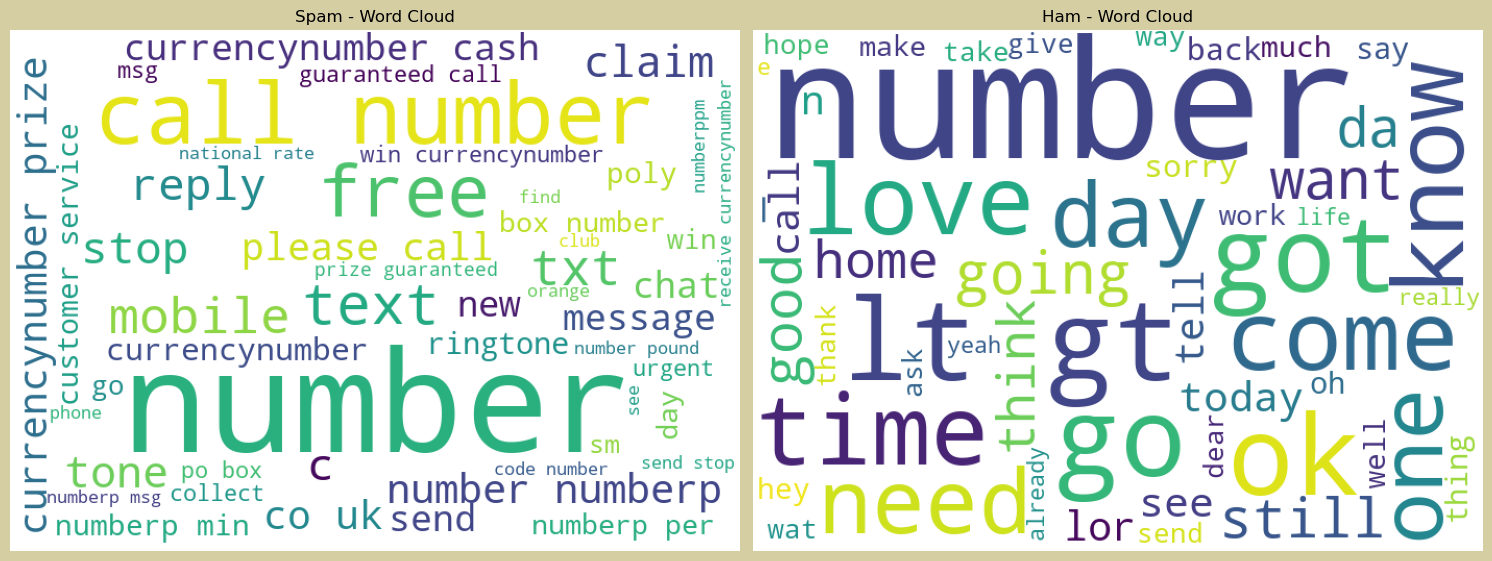

In [29]:
#Getting sense of loud words in spam and ham
from wordcloud import WordCloud
f,ax = plt.subplots(1,2,figsize = (15,8), facecolor='#D5CEA3')

spams = df['Lemmatized Text'][df['Labels']=='spam']
spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(spams))
ax[0].title.set_text('Spam - Word Cloud')
ax[0].imshow(spam_cloud)
ax[0].axis('off')

hams = df['Lemmatized Text'][df['Labels']=='ham']
ham_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(hams))
ax[1].title.set_text('Ham - Word Cloud')
ax[1].imshow(ham_cloud)
ax[1].axis('off')

plt.tight_layout(pad=1)
plt.show()

__Observation: 🔎__
- We can see Spam messages almost all of the times contain the following words/phrases:
    - `phonenumbers`
    - `prize guaranteed`
    - `claim prize`
    - `guaranteed`
    - `national rate`
    - `currencies`
    - `call number`
    - `win`
    - `chat`
    - `collect prize`

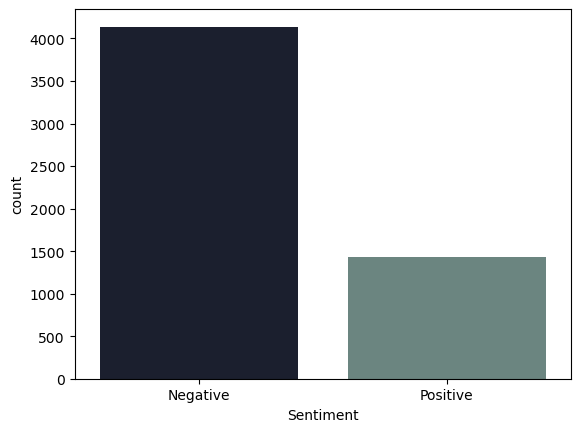

In [30]:
# visualizing the sentiment counts
sns.countplot(x=result['Sentiment'],palette=['#181D31','#678983'])
plt.show()

In [31]:
# checking if sentiment analysis can be used to aid in detecting spam or ham

# sum of total values in positive and negative sentiments
sum_of_positive = result['Labels'].groupby(result['Sentiment']).get_group('Positive').value_counts().sum()
sum_of_negative = result['Labels'].groupby(result['Sentiment']).get_group('Negative').value_counts().sum()

# ham and spam in positive sentiment
ham_positive = result['Labels'].groupby(result['Sentiment']).get_group('Positive').value_counts()[0]
spam_positive = result['Labels'].groupby(result['Sentiment']).get_group('Positive').value_counts()[1]

# ham and spam in negative sentiment
ham_negative = result['Labels'].groupby(result['Sentiment']).get_group('Negative').value_counts()[0]
spam_negative = result['Labels'].groupby(result['Sentiment']).get_group('Negative').value_counts()[1]

# creating a user-defined function to get percentage
def percent_of(num_a, num_b):
    return (num_a / num_b) * 100

# printing the percentage of spams and hams in each sentiment
print (f"Positive Sentiment:\n\
The percent of Hams: {round(percent_of(ham_positive, sum_of_positive),2)}%\n\
The percent of Spams: {round(percent_of(spam_positive, sum_of_positive),2)}%\n")

print (f"Negative Sentiment:\n\
The percent of Hams: {round(percent_of(ham_negative, sum_of_negative),2)}%\n\
The percent of Spams: {round(percent_of(spam_negative, sum_of_negative),2)}%")

Positive Sentiment:
The percent of Hams: 81.8%
The percent of Spams: 18.2%

Negative Sentiment:
The percent of Hams: 88.26%
The percent of Spams: 11.74%


__Observation: 🔎__
- __Higher percentage of Spam messages exhibit positive sentiments__, this is to influence the people to fall for it. Hence, why they use big words like `"win"`, `"claim prize"` & `"prize money"`. [Reference Link](https://morrispsych.com/why-so-many-people-fall-for-scams-by-kenneth-freundlich-ph-d/)
- Another method used by scammers is inducing a sense of urgency, this explains why they use words like `"urgent"` and `countdowns (date/time)` in messages/emails.

<div class='alert alert-success'>
    <b>6. Training the Model<b>
        <a id='training'></a>

In [32]:
from sklearn.utils import shuffle 
df_new = result.drop(['Polarity','Subjectivity','Sentiment'],axis=1)
df_new.head()

,Labels,Lemmatized Text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif oni
2,spam,free entry number wkly comp win fa cup final t...
3,ham,dun say early hor c already say
4,ham,nah think go usf life around though


In [33]:
# reindexing
df_new = df_new.reindex(columns=['Lemmatized Text','Labels'])
df_new.head()

,Lemmatized Text,Labels
0,go jurong point crazy available bugis n great ...,ham
1,ok lar joking wif oni,ham
2,free entry number wkly comp win fa cup final t...,spam
3,dun say early hor c already say,ham
4,nah think go usf life around though,ham


In [34]:
# saving the file before moving ahead
df_new.to_csv('data/cleaned_spam.csv') 

In [35]:
# splitting into train and test
# Select ratio
ratio = 0.75
  
total_rows = df_new.shape[0]
train_size = int(total_rows*ratio)
  
# Split data into test and train
train = df_new[0:train_size]
test = df_new[train_size:]

In [36]:
# turning the train dataframe into a trainable format → (text, label)
training = list(zip(train['Lemmatized Text'], df['Labels']))
# training the classifier model
cl = NaiveBayesClassifier(training)

In [37]:
# checking the accuracy of the model
testing = list(zip(test['Lemmatized Text'],test['Labels']))
print (f"The accuracy of the Naive Bayes Classifier Model is → {(round(cl.accuracy(testing),4))*100}%")

The accuracy of the Naive Bayes Classifier Model is → 98.42%


In [38]:
test['Labels'].value_counts()

ham     1211
spam     182
Name: Labels, dtype: int64

<div class='alert alert-success'>
    <b>7. Predicting Data<b>
        <a id='predicting'></a>

In [39]:
# creating a user-defined function to classify each message in a column
def classify_text(df, message_column):
    label_list = []
    for message in df[message_column]:
        label_list.append(cl.classify(message))
    
    return label_list

In [40]:
# creating a dataframe wihtout the labels column
df_classified = pd.DataFrame()
df_classified['Messages'] = test['Lemmatized Text']
df_classified['Labels'] = classify_text(df_classified, 'Messages')

In [41]:
# value counts of the predicted column
df_classified['Labels'].value_counts()

ham     1233
spam     160
Name: Labels, dtype: int64

<div class='alert alert-success'>
    <b>8. Performance of the Model<b>
        <a id='performance'></a>

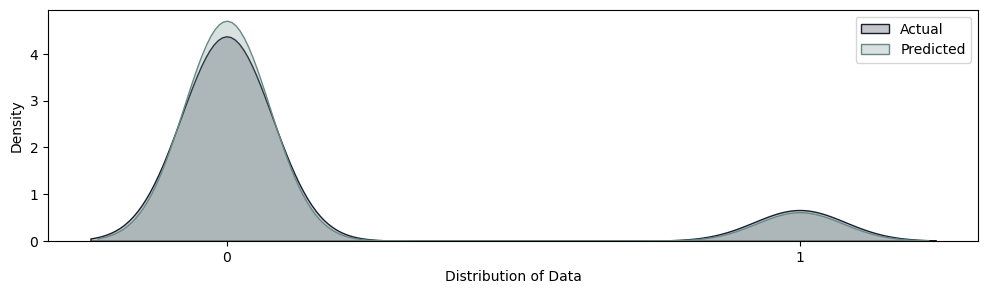

In [42]:
# creating a dataframe with the actual data and predicted data
actual_vs_predicted = pd.DataFrame({"Actual Data":test.Labels,"Predicted Data":df_classified.Labels})

#Label coding ham as 0 and spam as 1
actual_vs_predicted.replace({'ham':0,'spam':1},inplace=True)

# plotting the actual vs predicted data
plt.figure(figsize=(12,3))
sns.kdeplot(actual_vs_predicted['Actual Data'], color='#181D31', fill=True)
sns.kdeplot(actual_vs_predicted['Predicted Data'], color='#678983', fill=True)
plt.legend(['Actual','Predicted'])
plt.xlabel('Distribution of Data')
plt.xticks([0,1])
plt.show()

In [43]:
# a detailed view of how the classifier works 
cl.show_informative_features(5)

Most Informative Features
           contains(www) = True             spam : ham    =    270.4 : 1.0
         contains(nokia) = True             spam : ham    =    163.9 : 1.0
       contains(service) = True             spam : ham    =    144.3 : 1.0
contains(currencynumber) = True             spam : ham    =    108.6 : 1.0
           contains(txt) = True             spam : ham    =     92.0 : 1.0


__Conclusions:__
- Built a Naive Bayes Classifier Model using `TextBlob` library that classified messages as _spam_ or _ham_ with __98% accuracy__.
- As evident from the value counts of the testing data, to add to that a dataframe was created without the `Labels` column to see if the model was able to predict spam and ham. __It only mis-classified 22 messages from the total of 1393 messages; which can be considered successful!__
- A KDE plot of the `Actual Data` vs `Predicted Data` was viewed in the end to see how the model performed and used __.show_informative_features()__ command to get a more insightful idea on how the model predicted __SPAM or HAM__. 